In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


# 1. RNN을 활용한 Next token prediction

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Tones: 네(ne), 보내주신(bonaejusin), 코드(kodeu), 잘(jal), 보았습니다(boassseumnida).
# 2-layer(i-layer), RNN을(RNNeul), 구현하시려는(guhyeonhasiryeoneun), 목표를(mokpyoreul), 가지고(gajigo), 계시는군요(gyesineungunyo).
# 현재(hyeonjae), 작성하신(jakseonghasin), forward(forward), 함수는(hamsuneun), 2-layer(i-layer), RNN의(RNNui), 일반적인(ilbanjeogin), 동작(dongjak), 방식과는(bangsikgwaneun), 조금(jogeum), 다릅니다(dareumnida).
# PyTorch의(PyTorchui), nn.RNN(nn.RNN), 모듈을(modyureul), 사용하면(sayonghamyeon), 훨씬(hwolssin), 간단하고(gandanhago), 정확하게(jeonghwakhage), 다중(dajung), 레이어(reieo), RNN을(RNNeul), 구현할(guhyeonhal), 수(su), 있습니다(issseumnida).

sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

"""
Word Processing
"""
word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)


"""
TextRNN Parameter
"""
batch_size = len(sentences)
n_step = 2      # 학습 하려고 하는 문장의 길이 - 1
n_hidden = 5    # 은닉층 사이즈
n_layers = 2    # <<<--- RNN 레이어 개수 설정

def make_batch(sentences):
  input_batch = []
  target_batch = []

  for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    target = word_dict[word[-1]]

    input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
    target_batch.append(target)

  return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32) # requires_grad=True는 필요 없습니다.
target_batch = torch.tensor(target_batch, dtype=torch.int64)


"""
TextRNN
"""
class TextRNN(nn.Module):
  def __init__(self):
    super(TextRNN, self).__init__()

    # <<<--- 주요 변경점 1: num_layers=n_layers 로 2-layer RNN을 정의합니다.
    # dropout은 레이어가 2개 이상일 때, 마지막 레이어를 제외한 각 레이어의 출력에 적용됩니다.
    self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, num_layers=n_layers)

    # <<<--- 주요 변경점 2: W와 b를 직접 정의하는 대신 nn.Linear를 사용하는 것이 더 일반적이고 편리합니다.
    self.fc = nn.Linear(n_hidden, n_class)

  def forward(self, hidden, X):
    # <<<--- 주요 변경점 3: forward 로직을 매우 간단하게 만듭니다.
    # input: X.shape = (batch_size, n_step, n_class)
    X = X.transpose(0, 1) # X: (n_step, batch_size, n_class)

    # self.rnn에 한 번만 통과시키면 PyTorch가 내부적으로 2-layer 연산을 모두 처리해줍니다.
    # outputs: 각 time-step에서의 마지막 레이어의 은닉 상태들 (seq_len, batch, hidden_size)
    # hidden_n: 모든 레이어의 마지막 time-step의 은닉 상태 (num_layers, batch, hidden_size)
    outputs, hidden_n = self.rnn(X, hidden)

    # 최종 예측을 위해 마지막 time-step의 출력을 사용합니다.
    # outputs[-1]은 마지막 time-step의 은닉 상태입니다.
    final_output = outputs[-1]  # (batch_size, hidden_size)

    model = self.fc(final_output) # (batch_size, n_class)
    return model


"""
Training
"""
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
  # <<<--- 주요 변경점 4: 초기 은닉 상태의 shape은 (num_layers, batch_size, hidden_size)가 되어야 합니다.
  hidden = torch.zeros(n_layers, batch_size, n_hidden)

  output = model(hidden, input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

input = [sen.split()[:2] for sen in sentences]

# 예측
hidden = torch.zeros(n_layers, batch_size, n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

# 2. RNN을 활용한 주가 예측

In [ ]:
df = pd.read_csv('kospi.csv')
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000
...,...,...,...,...,...,...,...
426,2020-10-26,2366.500000,2374.500000,2342.580078,2343.909912,2343.909912,822300
427,2020-10-27,2328.659912,2349.330078,2321.229980,2330.840088,2330.840088,666900
428,2020-10-28,2324.179932,2345.459961,2316.469971,2345.260010,2345.260010,705200
429,2020-10-29,2312.340088,2330.169922,2299.909912,2326.669922,2326.669922,509100


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

df = pd.read_csv('kospi.csv')

# 사용할 데이터 (여기서는 'Close' 가격을 사용합니다.)
# 모든 수치형 컬럼을 사용하도록 변경
data_features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values.astype(np.float32)
data_close = df['Close'].values.astype(np.float32) # 예측을 위한 Close 데이터

"""
TextRNN Parameter (Note: Parameters are adjusted for sequential data)
"""
batch_size = 50  # 학습 데이터 묶음의 크기 (과거 데이터 몇 개를 볼 것인가)
n_hidden = 10     # 은닉층 사이즈
n_layers = 3     # RNN 레이어 개수 설정

# 데이터 스케일링 (RNN 학습 전에 데이터를 정규화하는 것이 일반적입니다.)
# 여기서는 간단하게 각 컬럼의 최대값으로 나누는 방식을 사용합니다.
# 실제 시계열 예측에서는 MinMaxScaler 등을 사용하는 것이 좋습니다.
# 각 컬럼별 최대값으로 스케일링
max_feature_values = np.max(data_features, axis=0)
data_features = data_features / max_feature_values
max_close_value = np.max(data_close) # Close 값만 별도로 스케일링
data_close = data_close / max_close_value


def make_batch(feature_data, target_data, sequence_length):
  input_batch = []
  target_batch = []

  # 슬라이딩 윈도우 방식으로 배치 생성
  # sequence_length는 과거 데이터 몇 개를 볼 것인지를 나타냅니다 (여기서는 batch_size와 동일).
  # 예측할 다음 값 하나를 위해 sequence_length 만큼의 feature 데이터와 다음 target 데이터 하나가 필요합니다.
  for i in range(len(feature_data) - sequence_length):
    input = feature_data[i : i + sequence_length] # 과거 sequence_length 만큼의 feature 데이터
    target = target_data[i + sequence_length]   # 그 다음 시점의 target 데이터 (예측 대상)

    input_batch.append(input) # shape: (sequence_length, num_features)
    target_batch.append([target]) # 예측 대상도 리스트 형태로 만들어 나중에 텐서 변환 시 차원 유지

  # numpy 배열로 변환 후 torch tensor로 변환
  input_batch = np.array(input_batch)
  target_batch = np.array(target_batch)

  input_batch = torch.tensor(input_batch, dtype=torch.float32)
  target_batch = torch.tensor(target_batch, dtype=torch.float32)

  return input_batch, target_batch

# 데이터를 훈련 세트와 테스트 세트로 분리
train_feature_data = data_features[:-100]
train_close_data = data_close[:-100]
test_feature_data = data_features[-100:] # 테스트 데이터의 feature는 사용하지 않습니다.
test_close_data = data_close[-100:]

# 훈련 데이터로 배치 생성 (batch_size를 sequence_length로 사용)
input_batch, target_batch = make_batch(train_feature_data, train_close_data, batch_size)

# input_size는 입력 데이터의 피처 수 (여기서는 'Open', 'High', 'Low', 'Close', 'Volume' 5개)
input_size = data_features.shape[1]


"""
TextRNN
"""
class TextRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(TextRNN, self).__init__()
    # batch_first=True로 설정하여 입력 텐서의 첫 번째 차원이 batch_size가 되도록 합니다.
    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1) # 다음 하나의 값을 예측하므로 출력은 1

  def forward(self, X):
    # X: (batch_size, seq_len, input_size) -> (batch_size, batch_size, 5) 여기서 seq_len은 make_batch의 sequence_length
    outputs, _ = self.rnn(X)
    # outputs: (batch_size, seq_len, hidden_size) -> (batch_size, batch_size, hidden_size)
    # 마지막 time-step의 출력을 사용합니다.
    final_output = outputs[:, -1, :]  # (batch_size, hidden_size)

    model = self.fc(final_output) # (batch_size, 1)
    return model


"""
Training
"""
model = TextRNN(input_size, n_hidden, n_layers)
# 회귀 문제이므로 MSE Loss를 사용합니다.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 데이터셋 크기
dataset_size = input_batch.size(0)

for epoch in range(5000): # 에포크 수 늘림
  # 각 에포크마다 전체 훈련 데이터셋을 순회하며 학습
  # 배치 단위 학습으로 수정
  output = model(input_batch) # input_batch 전체를 모델에 입력
  loss = criterion(output, target_batch) # 배치 전체에 대한 손실 계산

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 10 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss.item())) # loss.item()으로 스칼라 값 출력


"""
Prediction on Test Data
"""
# 테스트 데이터에 대한 input_batch 생성 (슬라이딩 윈도우 방식)
test_input_batch = []
test_target_batch = []

# 테스트 데이터 예측을 위해 훈련 데이터 마지막 batch_size 만큼과 테스트 데이터를 합쳐서 사용
# 여기서는 예측 시점의 이전 batch_size 만큼의 feature 데이터를 사용
combined_feature_data = np.concatenate((train_feature_data[-batch_size:], test_feature_data))
combined_close_data = np.concatenate((train_close_data[-batch_size:], test_close_data))


# 슬라이딩 윈도우 적용. combined_feature_data에서 batch_size 개를 보고 combined_close_data의 다음 1개를 예측.
# 예측은 test_close_data의 길이만큼 수행해야 합니다.
for i in range(len(test_close_data)):
    # 예측 시점 i 의 이전 batch_size 개 feature 데이터 사용
    input_sequence = combined_feature_data[i : i + batch_size]
    target_value = combined_close_data[i + batch_size]

    test_input_batch.append(input_sequence)
    test_target_batch.append([target_value])


test_input_batch = torch.tensor(np.array(test_input_batch), dtype=torch.float32)
test_target_batch = torch.tensor(np.array(test_target_batch), dtype=torch.float32)


# 테스트 데이터에 대한 예측 수행
model.eval() # 평가 모드
predicted_values = []

with torch.no_grad(): # gradient 계산 비활성화
    # test_input_batch의 각 시퀀스에 대해 예측 수행
    for i in range(test_input_batch.size(0)):
        current_test_input = test_input_batch[i].unsqueeze(0) # (1, batch_size, input_size) 형태로 모델에 입력
        predicted = model(current_test_input)
        predicted_values.append(predicted.item())

# 스케일링 되돌리기
# Ensure max_close_value is accessible, assuming it was calculated in a previous cell
# If not, calculate it here: max_close_value = np.max(df['Close'].values)
predicted_values = np.array(predicted_values) * np.max(df['Close'].values)
actual_values = test_target_batch.squeeze().numpy() * np.max(df['Close'].values)

print(f"Predicted values length: {len(predicted_values)}")
print(f"Actual values length: {len(actual_values)}")

Epoch: 0010 loss = 0.009541
Epoch: 0020 loss = 0.011367
Epoch: 0030 loss = 0.005773
Epoch: 0040 loss = 0.003291
Epoch: 0050 loss = 0.003419
Epoch: 0060 loss = 0.003372
Epoch: 0070 loss = 0.003231
Epoch: 0080 loss = 0.003247
Epoch: 0090 loss = 0.003227
Epoch: 0100 loss = 0.003227
Epoch: 0110 loss = 0.003222
Epoch: 0120 loss = 0.003220
Epoch: 0130 loss = 0.003216
Epoch: 0140 loss = 0.003213
Epoch: 0150 loss = 0.003209
Epoch: 0160 loss = 0.003204
Epoch: 0170 loss = 0.003199
Epoch: 0180 loss = 0.003193
Epoch: 0190 loss = 0.003186
Epoch: 0200 loss = 0.003178
Epoch: 0210 loss = 0.003167
Epoch: 0220 loss = 0.003155
Epoch: 0230 loss = 0.003139
Epoch: 0240 loss = 0.003118
Epoch: 0250 loss = 0.003090
Epoch: 0260 loss = 0.003052
Epoch: 0270 loss = 0.002997
Epoch: 0280 loss = 0.002911
Epoch: 0290 loss = 0.002771
Epoch: 0300 loss = 0.002534
Epoch: 0310 loss = 0.002097
Epoch: 0320 loss = 0.001302
Epoch: 0330 loss = 0.001203
Epoch: 0340 loss = 0.004458
Epoch: 0350 loss = 0.003054
Epoch: 0360 loss = 0

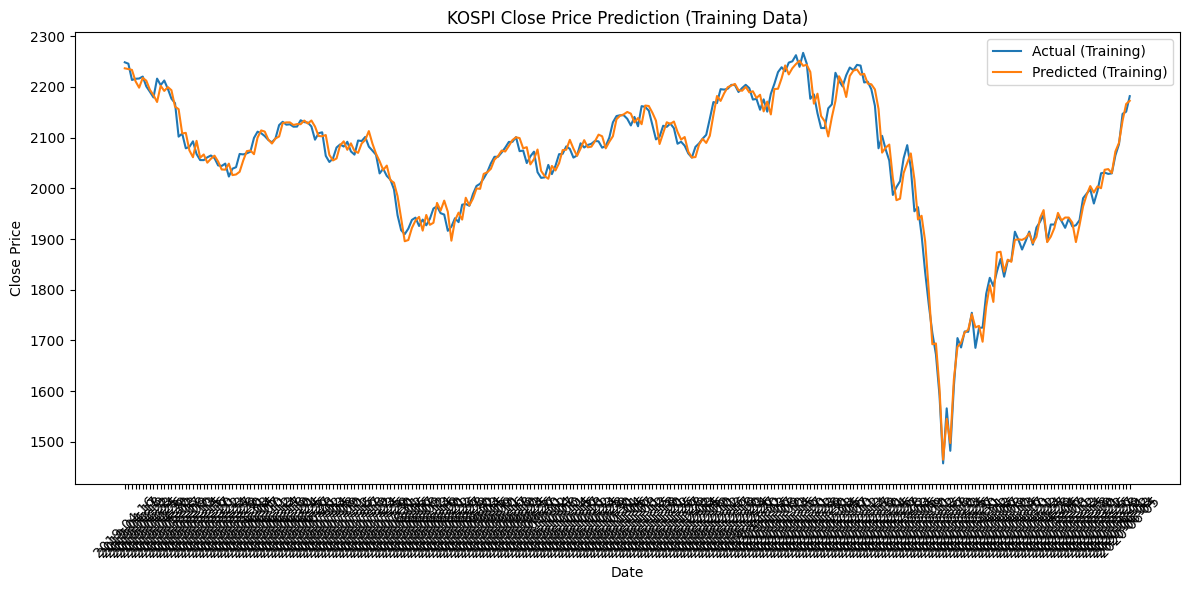

In [ ]:
# 학습 과정에서의 실제 값과 예측 값 비교 시각화
model.eval() # 평가 모드로 전환
predicted_train_values = []

with torch.no_grad(): # gradient 계산 비활성화
    # 훈련 데이터 전체에 대한 예측 수행
    train_output = model(input_batch)
    predicted_train_values = train_output.squeeze().numpy() * np.max(df['Close'].values)

actual_train_values = target_batch.squeeze().numpy() * np.max(df['Close'].values)

plt.figure(figsize=(12, 6))
# 날짜 인덱스를 실제 훈련 데이터 예측이 시작되는 시점부터 맞춥니다.
# 훈련 데이터는 df의 시작부터 len(train_close_data)까지이고, 예측은 batch_size 이후부터 가능합니다.
plt.plot(df['Date'].values[batch_size  : len(train_close_data)], actual_train_values, label='Actual (Training)')
plt.plot(df['Date'].values[batch_size  : len(train_close_data)], predicted_train_values, label='Predicted (Training)')

plt.title('KOSPI Close Price Prediction (Training Data)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

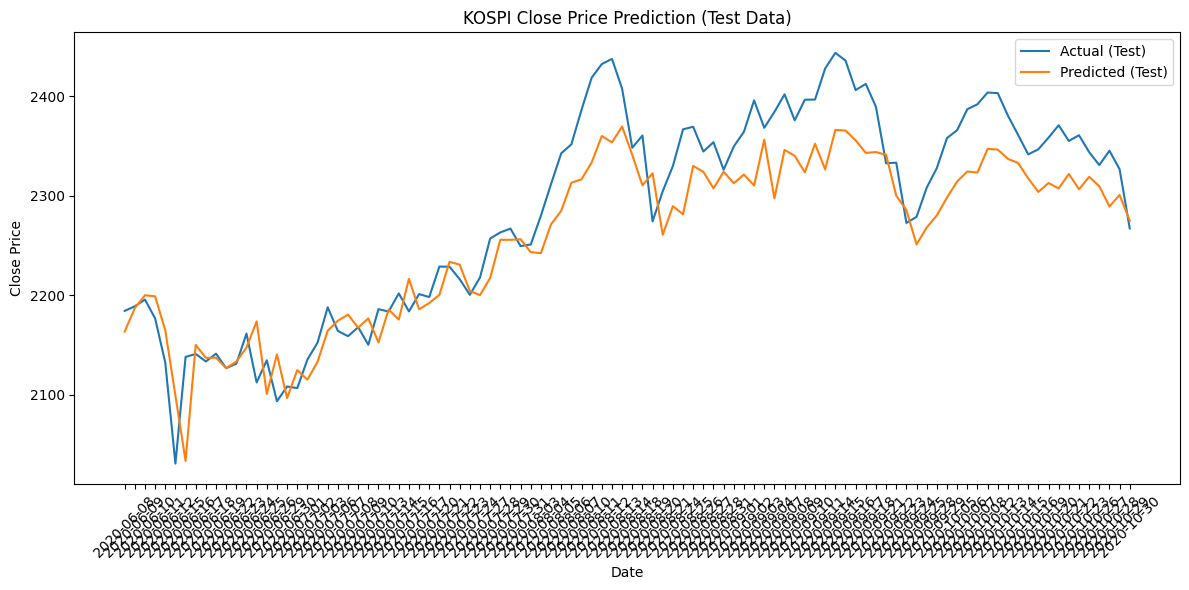

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
# 실제 값은 test_data의 batch_size 이후부터 시작합니다.
# 훈련 데이터 길이와 batch_size를 고려하여 날짜 인덱스 보정
test_start_index = len(train_close_data)
plt.plot(df['Date'].values[test_start_index : test_start_index + len(actual_values)], actual_values, label='Actual (Test)')
# 예측 값은 실제 값과 동일한 시점에 대응됩니다. 사용자의 요청에 따라 시각적 정렬을 위해 2칸 오른쪽으로 이동.
plt.plot(df['Date'].values[test_start_index : test_start_index + len(predicted_values)], predicted_values, label='Predicted (Test)')

plt.title('KOSPI Close Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45) # x축 레이블 회전
plt.tight_layout() # 레이아웃 조정
plt.legend()
plt.show()

# 3. LSTM을 활용한 주가 예측

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler 임포트

df = pd.read_csv('kospi.csv')

# 사용할 데이터 (여기서는 'Close' 가격을 사용합니다.)
# 모든 수치형 컬럼을 사용하도록 변경
data_features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values.astype(np.float32)
data_close = df['Close'].values.astype(np.float32).reshape(-1, 1) # MinMaxScaler는 2D 입력을 기대하므로 reshape

"""
LSTM Parameter (Adjusted from RNN parameters)
"""
batch_size = 10  # 학습 데이터 묶음의 크기 (과거 데이터 몇 개를 볼 것인가)
n_hidden = 5     # 은닉층 사이즈
n_layers = 2     # LSTM 레이어 개수 설정

# 데이터 스케일링 (LSTM 학습 전에 데이터를 정규화하는 것이 일반적입니다.)
# MinMaxScaler 사용
feature_scaler = MinMaxScaler()
close_scaler = MinMaxScaler()


def make_batch(feature_data, target_data, sequence_length):
  input_batch = []
  target_batch = []

  for i in range(len(feature_data) - sequence_length):
    input = feature_data[i : i + sequence_length]
    target = target_data[i + sequence_length]

    input_batch.append(input)
    target_batch.append(target)

  input_batch = np.array(input_batch)
  target_batch = np.array(target_batch)

  input_batch = torch.tensor(input_batch, dtype=torch.float32)
  target_batch = torch.tensor(target_batch, dtype=torch.float32)

  return input_batch, target_batch

# 데이터를 훈련 세트와 테스트 세트로 분리
train_feature_data = data_features[:-100]
train_close_data = data_close[:-100]
test_feature_data = data_features[-100:]
test_close_data = data_close[-100:]

# 스케일러를 훈련 데이터에만 fit 합니다.
train_feature_scaled = feature_scaler.fit_transform(train_feature_data)
train_close_scaled = close_scaler.fit_transform(train_close_data)

# 테스트 데이터는 훈련 데이터에 fit된 스케일러로 transform 합니다.
test_feature_scaled = feature_scaler.transform(test_feature_data)
test_close_scaled = close_scaler.transform(test_close_data)


# 훈련 데이터로 배치 생성 (스케일링된 데이터 사용)
input_batch, target_batch = make_batch(train_feature_scaled, train_close_scaled, batch_size)

# input_size는 입력 데이터의 피처 수 (여기서는 'Open', 'High', 'Low', 'Close', 'Volume' 5개)
input_size = data_features.shape[1]


"""
TextLSTM
"""
class TextLSTM(nn.Module): # 클래스 이름 변경
  def __init__(self, input_size, hidden_size, num_layers):
    super(TextLSTM, self).__init__()
    # <<<--- 변경: nn.RNN 대신 nn.LSTM 사용
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, X):
    # X: (batch_size, seq_len, input_size)
    # LSTM의 출력은 (output, (h_n, c_n)) 입니다.
    outputs, (h_n, c_n) = self.lstm(X)
    # outputs: (batch_size, seq_len, hidden_size)
    # 최종 예측을 위해 마지막 time-step의 은닉 상태 (h_n의 마지막 레이어)를 사용합니다.
    # LSTM의 h_n은 (num_layers, batch_size, hidden_size) 형태입니다.
    final_output = h_n[-1, :, :]  # (batch_size, hidden_size)

    model = self.fc(final_output) # (batch_size, 1)
    return model


"""
Training (LSTM)
"""
model_lstm = TextLSTM(input_size, n_hidden, n_layers) # 모델 인스턴스 이름 변경
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.01) # 옵티마이저에 LSTM 모델 파라미터 전달

dataset_size = input_batch.size(0)

for epoch in range(500): # 에포크 수 조정 가능
  # 각 에포크마다 전체 훈련 데이터셋을 순회하며 학습
  output = model_lstm(input_batch) # LSTM 모델 사용
  loss = criterion(output, target_batch)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss.item()))


"""
Prediction on Test Data (LSTM)
"""
# 테스트 데이터에 대한 input_batch 생성 (스케일링된 데이터 사용)
# make_batch 함수는 그대로 사용
# combined_feature_scaled_data와 combined_close_scaled_data는 위에서 이미 생성됨

# 테스트 데이터 예측을 위해 훈련 데이터 마지막 batch_size 만큼과 테스트 데이터를 합쳐서 사용
# 여기서는 스케일링된 데이터를 사용합니다.
combined_feature_scaled_data = np.concatenate((train_feature_scaled[-batch_size:], test_feature_scaled))
combined_close_scaled_data = np.concatenate((train_close_scaled[-batch_size:], test_close_scaled))


test_input_batch, test_target_batch = make_batch(combined_feature_scaled_data[:-1], combined_close_scaled_data[:-1].squeeze(), batch_size) # 마지막 타겟 제외


# 테스트 데이터에 대한 예측 수행
model_lstm.eval() # 평가 모드
predicted_scaled_values_lstm = [] # 예측 결과 저장 리스트 변경

with torch.no_grad():
    for i in range(test_input_batch.size(0)):
        current_test_input = test_input_batch[i].unsqueeze(0)
        predicted = model_lstm(current_test_input) # LSTM 모델 사용
        predicted_scaled_values_lstm.append(predicted.item())

# 스케일링 되돌리기
predicted_values_lstm = close_scaler.inverse_transform(np.array(predicted_scaled_values_lstm).reshape(-1, 1)).flatten()
# actual_values는 이미 위에서 계산된 test_target_batch를 사용하거나 다시 계산
actual_values_lstm = close_scaler.inverse_transform(test_target_batch.squeeze().numpy().reshape(-1, 1)).flatten()

print(f"Predicted values length (LSTM): {len(predicted_values_lstm)}")
print(f"Actual values length (LSTM): {len(actual_values_lstm)}")

Epoch: 0100 cost = 0.009286
Epoch: 0200 cost = 0.002727
Epoch: 0300 cost = 0.001573
Epoch: 0400 cost = 0.001343
Epoch: 0500 cost = 0.001225
Predicted values length (LSTM): 99
Actual values length (LSTM): 99


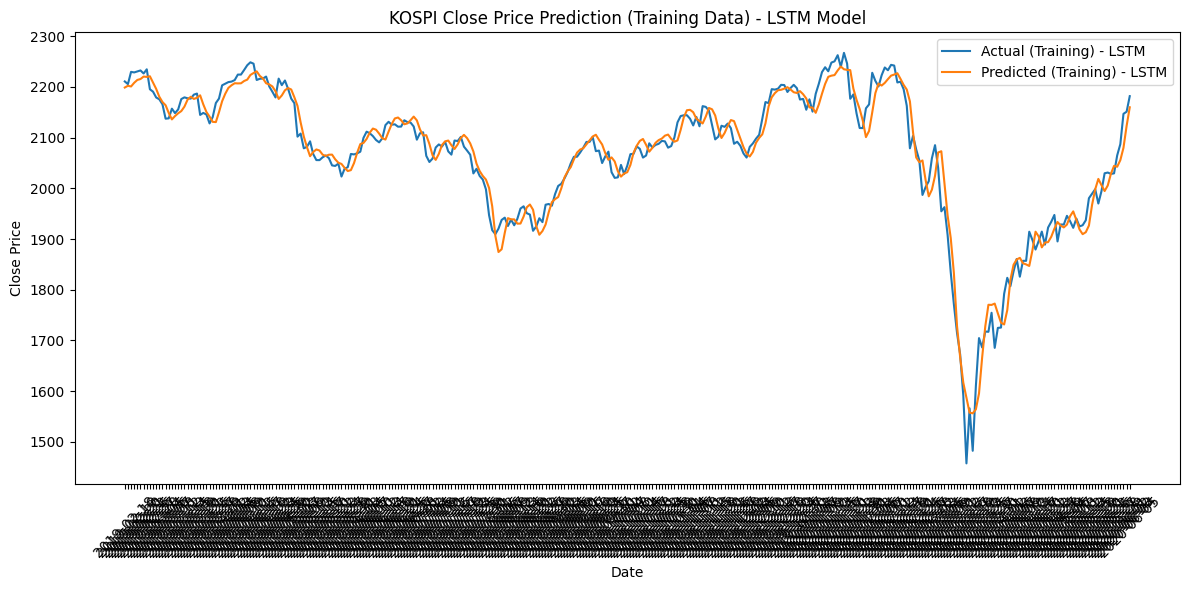

In [ ]:
import matplotlib.pyplot as plt

# LSTM 모델 학습 과정에서의 실제 값과 예측 값 비교 시각화
model_lstm.eval() # 평가 모드로 전환
predicted_train_scaled_values_lstm = []

with torch.no_grad(): # gradient 계산 비활성화
    # 訓練データ全体に対する予測を実行
    train_output_lstm = model_lstm(input_batch)
    predicted_train_scaled_values_lstm = train_output_lstm.squeeze().numpy()

# 스케일링 되돌리기
predicted_train_values_lstm = close_scaler.inverse_transform(predicted_train_scaled_values_lstm.reshape(-1, 1)).flatten()
actual_train_values_lstm = close_scaler.inverse_transform(target_batch.squeeze().numpy().reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
# 날짜 인덱스는 훈련 데이터의 시작부터 예측이 가능한 시점부터 맞춥니다.
# input_batch의 첫 번째 요소는 원본 데이터의 batch_size 인덱스에 해당하며, 예측은 그 다음 날에 대한 것입니다.
# 따라서 훈련 예측 결과는 df['Date'].values[batch_size] 부터 시작하여 len(actual_train_values_lstm) 만큼의 길이를 가집니다.
# 훈련 데이터는 df의 시작부터 len(train_close_data)까지이고, 예측은 batch_size 이후부터 가능합니다.
plt.plot(df['Date'].values[batch_size : len(train_close_data)], actual_train_values_lstm, label='Actual (Training) - LSTM')
plt.plot(df['Date'].values[batch_size : len(train_close_data)], predicted_train_values_lstm, label='Predicted (Training) - LSTM')


plt.title('KOSPI Close Price Prediction (Training Data) - LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

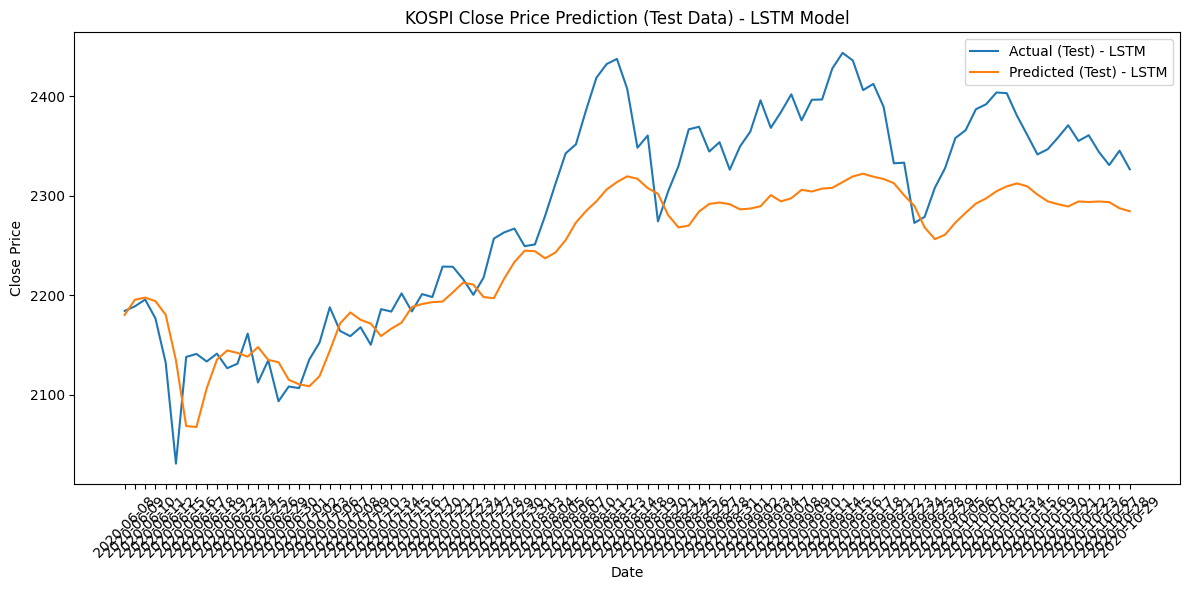

In [ ]:
import matplotlib.pyplot as plt

# LSTM 모델 예측 결과 시각화
plt.figure(figsize=(12, 6))
# 테스트 데이터의 실제 값과 LSTM 모델의 예측값 시각화
# 날짜 인덱스는 RNN 시각화와 동일하게 테스트 데이터 시작 시점부터 사용합니다.
test_start_index = len(train_close_data) # train_close_data는 스케일링되지 않은 원본 데이터 길이 기준
plt.plot(df['Date'].values[test_start_index : test_start_index + len(actual_values_lstm)], actual_values_lstm, label='Actual (Test) - LSTM')
# LSTM 예측 값은 실제 값과 동일한 시점에 대응됩니다. 시각적 정렬을 위한 이동은 사용하지 않습니다.
plt.plot(df['Date'].values[test_start_index : test_start_index + len(predicted_values_lstm)], predicted_values_lstm, label='Predicted (Test) - LSTM')

plt.title('KOSPI Close Price Prediction (Test Data) - LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45) # x축 레이블 회전
plt.tight_layout() # 레이아웃 조정
plt.legend()
plt.show()

# 4. 결론
- RNN 기반 모델들의 특징과 window sliding(batch_size=10)을 활용하여, 가장 최신 과거 정보들을 학습해서 test 과정에서 예측 그래프가 실제 그래프보다 오른쪽으로 밀려 있는 것 같은 결과가 나왔다.
- LSTM모델을 활용하거나 batch_size를 늘려도 오른쪽으로 편향되는 문제를 해결하지는 못했다.